## Men-Women Detection
Using Transfer Learning + Data Augmentation

In [ ]:
import os
import shutil, pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers

## 1- Dataset Preparation

### 1-1. Download Dataset from Kaggle

In [ ]:
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d saadpd/menwomen-classification

100% 804M/806M [00:35<00:00, 24.6MB/s]
100% 806M/806M [00:35<00:00, 23.7MB/s]


In [ ]:
!unzip -qq menwomen-classification.zip

### 1-2. Dataset Evaluation

In [ ]:
num_men_train = len(os.listdir('traindata/traindata/men'))
num_women_train = len(os.listdir('traindata/traindata/women'))
num_men_test = len(os.listdir('testdata/testdata/men'))
num_women_test = len(os.listdir('testdata/testdata/women'))

print(f'Train: men: {num_men_train} | women: {num_women_train}')
print(f'Test: men: {num_men_test} | women: {num_women_test}')

Train: men: 1000 | women: 1912
Test: men: 418 | women: 915


### 1-3. Prepare Data Directories

In [ ]:
new_base_dir = pathlib.Path("men_vs_women_small")

def make_subset(base_dir, subset_name, start_index, end_index):
    for category in ("men", "women"):
        dir = new_base_dir / subset_name / category
        if not os.path.exists(dir):
            os.makedirs(dir)
        files = os.listdir(os.path.join(base_dir, category))
        fnames = [files[i] for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=os.path.join(base_dir, category, fname),
            dst=os.path.join(dir, fname))

In [ ]:
make_subset("traindata/traindata", "validation", start_index=0, end_index=200)
make_subset("traindata/traindata", "train", start_index=200, end_index=999)
make_subset("testdata/testdata", "test", start_index=0, end_index=400)

### 1-4. Load Dataset

In [ ]:
print('Train loader:')
train_dataset = image_dataset_from_directory(
    'men_vs_women_small/train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary'
)

print('Validation loader:')
validation_dataset = image_dataset_from_directory(
    'men_vs_women_small/validation',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary'
)

print('Test loader:')
test_dataset = image_dataset_from_directory(
    'men_vs_women_small/test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary'
)

Train loader:
Found 1598 files belonging to 2 classes.
Validation loader:
Found 400 files belonging to 2 classes.
Test loader:
Found 800 files belonging to 2 classes.


data batch shape: (32, 180, 180, 3)
label batch shape: (32, 1)


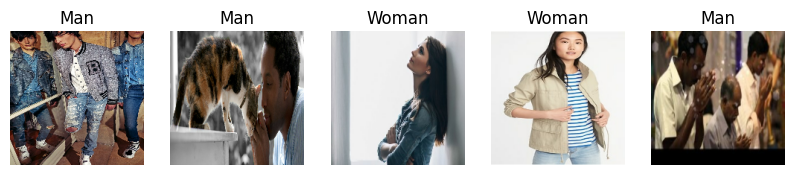

In [ ]:
for data_batch, label_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('label batch shape:', label_batch.shape)

    # Show five random examples of the loaded batch
    fig, axes = plt.subplots(1, 5, figsize=(10,3))
    for i, ax in enumerate(axes):
        ax.imshow(data_batch[i].numpy().astype('uint8'))
        ax.set_axis_off()
        ax.set_title('Man' if label_batch[i].numpy()==0 else 'Woman')
    break

plt.show()

## 2- Model Design

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 180, 180, 3)       0         
 7 (SlicingOpLambda)                                             
                                                                 
 tf.nn.bias_add_17 (TFOpLam  (None, 180, 180, 3)       0         
 bda)                                                            
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0  

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_transfer_learning.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 19s 321ms/step - loss: 2.0694 - accuracy: 0.7065 - val_loss: 1.0615 - val_accuracy: 0.8425
Epoch 2/30
50/50 [==============================] - 18s 314ms/step - loss: 1.2881 - accuracy: 0.7947 - val_loss: 1.0371 - val_accuracy: 0.8625
Epoch 3/30
50/50 [==============================] - 17s 309ms/step - loss: 1.2488 - accuracy: 0.8048 - val_loss: 1.0971 - val_accuracy: 0.8575
Epoch 4/30
50/50 [==============================] - 18s 309ms/step - loss: 1.0820 - accuracy: 0.8204 - val_loss: 0.9823 - val_accuracy: 0.8600
Epoch 5/30
50/50 [==============================] - 17s 308ms/step - loss: 1.0138 - accuracy: 0.8179 - val_loss: 1.0844 - val_accuracy: 0.8600
Epoch 6/30
50/50 [==============================] - 17s 309ms/step - loss: 0.9014 - accuracy: 0.8254 - val_loss: 0.9673 - val_accuracy: 0.8475
Epoch 7/30
50/50 [==============================] - 18s 305ms/step - loss: 0.8682 - accuracy: 0.8310 - val_loss: 0.8363 - val_accuracy: 0.8775

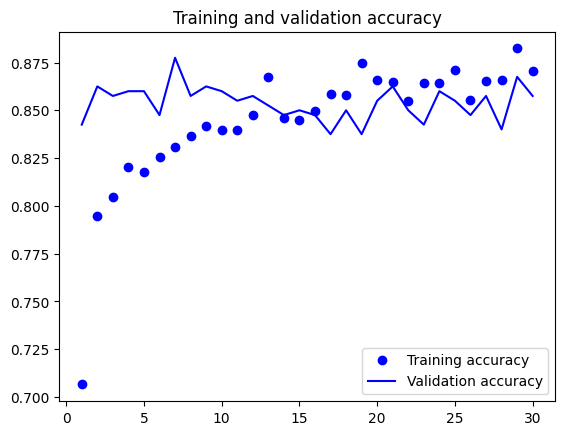

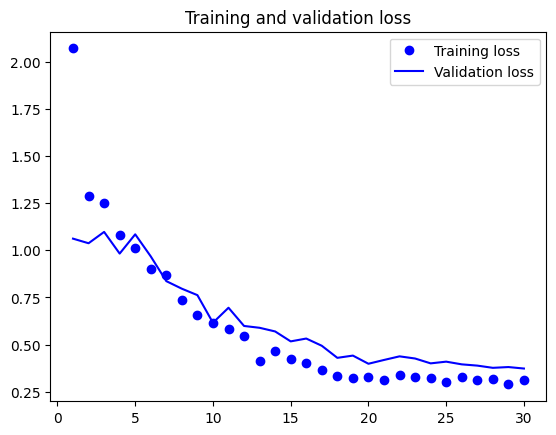

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_transfer_learning.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

25/25 [==============================] - 8s 226ms/step - loss: 0.3484 - accuracy: 0.8575
Test accuracy: 0.858


In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [62]:
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 180, 180, 3)       0         
 7 (SlicingOpLambda)                                             
                                                                 
 tf.nn.bias_add_17 (TFOpLam  (None, 180, 180, 3)       0         
 bda)                                                            
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0  

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

In [59]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.h5",
        save_best_only=True,
        monitor="val_loss")
]
history2 = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 17s 315ms/step - loss: 0.2379 - accuracy: 0.9018 - val_loss: 0.3644 - val_accuracy: 0.8850


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
50/50 [==============================] - 18s 305ms/step - loss: 0.1976 - accuracy: 0.9186 - val_loss: 0.3366 - val_accuracy: 0.9025
Epoch 3/30
50/50 [==============================] - 18s 339ms/step - loss: 0.1996 - accuracy: 0.9130 - val_loss: 0.3299 - val_accuracy: 0.9050
Epoch 4/30
50/50 [==============================] - 18s 319ms/step - loss: 0.1732 - accuracy: 0.9305 - val_loss: 0.3394 - val_accuracy: 0.8825
Epoch 5/30
50/50 [==============================] - 17s 308ms/step - loss: 0.1314 - accuracy: 0.9531 - val_loss: 0.3546 - val_accuracy: 0.9000
Epoch 6/30
50/50 [==============================] - 18s 302ms/step - loss: 0.1525 - accuracy: 0.9431 - val_loss: 0.3488 - val_accuracy: 0.8850
Epoch 7/30
50/50 [==============================] - 17s 309ms/step - loss: 0.1103 - accuracy: 0.9599 - val_loss: 0.3557 - val_accuracy: 0.9125
Epoch 8/30
50/50 [==============================] - 17s 310ms/step - loss: 0.1018 - accuracy: 0.9637 - val_loss: 0.3752 - val_accuracy: 0.9025

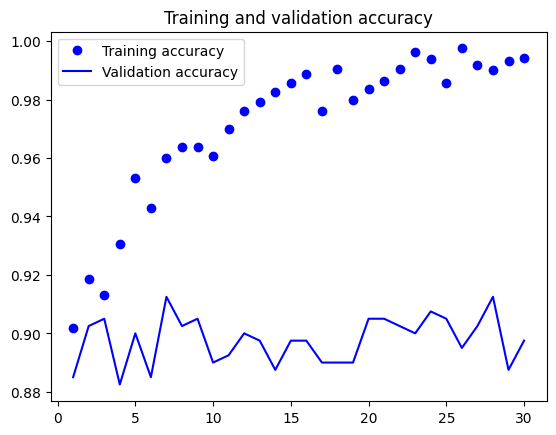

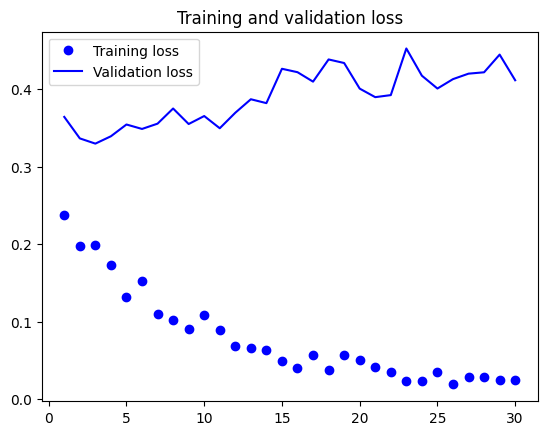

In [60]:
accuracy = history2.history["accuracy"]
val_accuracy = history2.history["val_accuracy"]
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [61]:
test_model = keras.models.load_model("fine_tuning.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

25/25 [==============================] - 7s 208ms/step - loss: 0.2483 - accuracy: 0.9087
Test accuracy: 0.909
